In [1]:
pip install mitdeeplearning

     |████████████████████████████████| 2.1 MB 2.9 MB/s 
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.2.0-py3-none-any.whl size=2115443 sha256=487ab135fb6e21cb6ebfc8bc964d118d425e71382669e2d239e47ad09627e3f6
  Stored in directory: /root/.cache/pip/wheels/9a/b9/4f/99b7c8c5c75355550b83e1fcfc02956fb40c35eb01e2262877
Successfully built mitdeeplearning
Note: you may need to restart the kernel to use updated packages.


In [2]:
import mitdeeplearning as mdl

In [3]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras import layers as L
import tensorflow.keras.preprocessing.image as imgPrep
import os
import pandas as pd
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

###Constant###
EPOCHS = 50
DCNN_EPOCHS = 25
SMOOTHING_FAC = 0

# Begin Designing Autoencoder

In [4]:
def get_data():
    data_gen = imgPrep.ImageDataGenerator(rescale=1./255, validation_split=0.2)
    train_generator = data_gen.flow_from_directory(r'../input/cgan-isic-dataset/FullTrainingData',
                                                  target_size=(256, 256),
                                                  batch_size=16,
                                                  class_mode='input',
                                                  subset='training',
                                                  shuffle=True)
    valid_generator = data_gen.flow_from_directory(r'../input/cgan-isic-dataset/FullTrainingData',
                                                  target_size=(256, 256),
                                                  batch_size=1,
                                                  class_mode='input',
                                                  subset='validation',
                                                  shuffle=True)
    return train_generator, valid_generator

In [5]:
n_filters = 12
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean
    
def create_train_autoencoder(epochs=3):
    train_generator, valid_generator = get_data()
    latent_dims = 100
    inputs = L.Input(shape=[256, 256, 3])
    conv1 = L.Conv2D(filters=1*n_filters, kernel_size=5, 
                       strides=2, padding='same', activation='relu', name='conv1')(inputs)
    batch1 = L.BatchNormalization(name='batch1')(conv1)

    conv2 = L.Conv2D(filters=2*n_filters, kernel_size=5, 
                       strides=2, padding='same', activation='relu', name='conv2')(batch1)
    batch2 = L.BatchNormalization(name='batch2')(conv2)

    conv3 = L.Conv2D(filters=4*n_filters, kernel_size=5, 
                       strides=2, padding='same', activation='relu', name='conv3')(batch2)
    batch3 = L.BatchNormalization(name='batch3')(conv3)

    conv4 = L.Conv2D(filters=6*n_filters, kernel_size=5, 
                       strides=2, padding='same', activation='relu', name='conv4')(batch3)
    batch4 = L.BatchNormalization(name='batch4')(conv4)

    conv5 = L.Conv2D(filters=8*n_filters, kernel_size=5, 
                       strides=2, padding='same', activation='relu', name='conv5')(batch4)
    batch5 = L.BatchNormalization(name='batch5')(conv5)

    z = L.Flatten()(batch5)
    z = L.Dense(512)(z)
    codings = L.Dense(latent_dims)(z)
    # codings_mean = L.Dense(latent_dims)(z)
    # codings_log_var = L.Dense(latent_dims)(z)
    # codings = Sampling()([codings_mean, codings_log_var])
    encoder = tf.keras.models.Model(inputs=[inputs], 
                                    outputs=[codings])
    decoder_inputs = L.Input(shape=[latent_dims])
    x = L.Dense(units=8*8*8*n_filters, activation='relu')(decoder_inputs)
    x = L.Reshape(target_shape=(8, 8, 8*n_filters))(x)
    x = L.Conv2DTranspose(filters=6*n_filters, kernel_size=5,  
                          strides=2, padding='same', activation='relu')(x)

    x = L.Conv2DTranspose(filters=4*n_filters, kernel_size=5,  
                          strides=2, padding='same', activation='relu')(x)
    x = L.Conv2DTranspose(filters=2*n_filters, kernel_size=5,  
                          strides=2, padding='same', activation='relu')(x)
    x = L.Conv2DTranspose(filters=1*n_filters, kernel_size=5,  
                          strides=2, padding='same', activation='relu')(x)
    outputs = L.Conv2DTranspose(filters=3, kernel_size=5,  
                          strides=2, padding='same', activation='relu')(x)
    decoder = tf.keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])
    codings = encoder(inputs)
    recons = decoder(codings)
    VAE = tf.keras.models.Model(inputs=[inputs], outputs=[recons])


    learning_rate = 5e-4
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    VAE.compile(loss='mse', optimizer=optimizer)
    VAE.summary()
    TRAIN_STEPS = train_generator.n//train_generator.batch_size
    VAL_STEPS = valid_generator.n//valid_generator.batch_size
    VAE.fit(train_generator, epochs=epochs, 
            validation_data=valid_generator, 
            steps_per_epoch=TRAIN_STEPS,
           validation_steps=VAL_STEPS)
    return inputs, batch5

In [6]:
inputs_stdrd, batch5_stdrd = create_train_autoencoder(epochs=1)

Found 26501 images belonging to 1 classes.
Found 6625 images belonging to 1 classes.
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
model (Functional)           (None, 100)               3494900   
_________________________________________________________________
model_1 (Functional)         (None, 256, 256, 3)       916803    
Total params: 4,411,703
Trainable params: 4,411,199
Non-trainable params: 504
_________________________________________________________________
1656/1656 [==============================] - 379s 226ms/step - loss: 0.0391 - val_loss: 0.0055


### Create New Standard Model

In [7]:
def baseline_pretrained(n_outputs=1):
    flat = L.Flatten()(batch5_stdrd)
    y = L.Dense(512)(flat)
    y = L.Dense(n_outputs, activation=None)(y)
    return tf.keras.models.Model(inputs=[inputs_stdrd], outputs=[y])

In [8]:
model = baseline_pretrained()
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 128, 128, 12)      912       
_________________________________________________________________
batch1 (BatchNormalization)  (None, 128, 128, 12)      48        
_________________________________________________________________
conv2 (Conv2D)               (None, 64, 64, 24)        7224      
_________________________________________________________________
batch2 (BatchNormalization)  (None, 64, 64, 24)        96        
_________________________________________________________________
conv3 (Conv2D)               (None, 32, 32, 48)        28848     
_________________________________________________________________
batch3 (BatchNormalization)  (None, 32, 32, 48)        192 

In [9]:
data_path = r'../input/melanoma-h5-dataset/short_data.h5'
cache = h5py.File(data_path, 'r')
images = cache['images'][:]

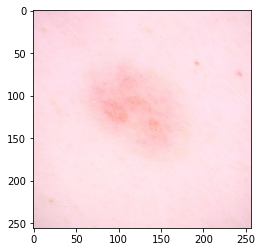

In [10]:
plt.imshow(images[0])

In [11]:
labels = cache['labels'][:].astype(np.float32)
labels = labels.reshape(-1, 1)

In [12]:
number_of_training_examples = images.shape[0]
image_dims = images.shape
n_train_samples = image_dims[0]
train_inds = np.random.permutation(np.arange(n_train_samples))
pos_train_inds = train_inds[labels[train_inds, 0] == 1.0 ]
neg_train_inds = train_inds[labels[train_inds, 0] != 1.0 ]

In [13]:
def get_batch(n, only_faces=False, p_pos=None, p_neg=None, return_inds=False):
    if only_faces:
            selected_inds = np.random.choice(pos_train_inds, size=n, replace=False, p=p_pos)
    else:
        selected_pos_inds = np.random.choice(pos_train_inds, size=n//2, replace=False, p=p_pos)
        selected_neg_inds = np.random.choice(neg_train_inds, size=n//2, replace=False, p=p_neg)
        selected_inds = np.concatenate((selected_pos_inds, selected_neg_inds))
    sorted_inds = np.sort(selected_inds)
    train_img = (images[sorted_inds,:,:,::]).astype(np.float32)
    train_label = labels[sorted_inds,...]
    return (train_img, train_label, sorted_inds) if return_inds else (train_img, train_label)

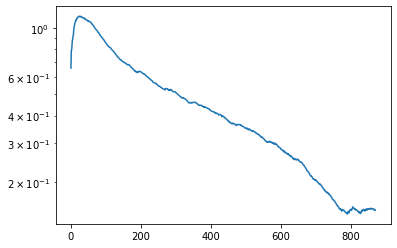

100%|██████████| 36/36 [00:01<00:00, 21.50it/s]


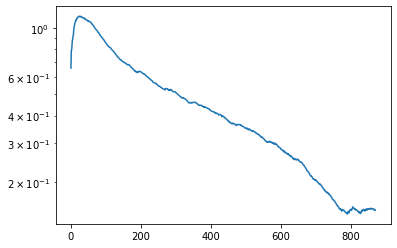

In [14]:
batch_size = 32
num_epochs = DCNN_EPOCHS
learning_rate = 5e-4

optimizer = tf.keras.optimizers.Adam(learning_rate) # define our optimizer
loss_history = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

    
@tf.function
def standard_train_step(x, y):
    with tf.GradientTape() as tape:
        # feed the images into the model
        logits = model(x) 
        
        # Compute the loss
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

  # Backpropagation
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

# The training loop!
for epoch in range(num_epochs):
    for idx in tqdm(range(n_train_samples//batch_size)):
        # Grab a batch of training data and propagate through the network
        x, y = get_batch(batch_size)
        loss = standard_train_step(x, y)

        # Record the loss and plot the evolution of the loss as a function of training
        loss_history.append(loss.numpy().mean())
        plotter.plot(loss_history.get())

In [15]:
inputs_latent, batch5_latent = create_train_autoencoder(epochs=1)

Found 26501 images belonging to 1 classes.
Found 6625 images belonging to 1 classes.
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
model_4 (Functional)         (None, 100)               3494900   
_________________________________________________________________
model_5 (Functional)         (None, 256, 256, 3)       916803    
Total params: 4,411,703
Trainable params: 4,411,199
Non-trainable params: 504
_________________________________________________________________
1656/1656 [==============================] - 221s 133ms/step - loss: 0.0391 - val_loss: 0.0045


In [16]:
def new_standard_model(n_outputs):
    flat = L.Flatten()(batch5_latent)
    y = L.Dense(512)(flat)
    y = L.Dense(n_outputs, activation=None)(y)
    return tf.keras.models.Model(inputs=[inputs_latent], outputs=[y])

In [17]:
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):

    latent_loss = tf.reduce_sum(tf.exp(logsigma)+mu**2-1-logsigma, axis=1)*0.5


    reconstruction_loss = tf.reduce_mean(tf.abs(x-x_recon), axis=(1, 2, 3))

    vae_loss = kl_weight*latent_loss+reconstruction_loss

    return vae_loss

In [18]:
def sampling(z_mean, z_logsigma):
    batch, latent_dim = z_mean.shape
    epsilon = tf.random.normal(shape=(batch, latent_dim))

    z = z_mean+tf.exp(0.5*z_logsigma)*epsilon
    return z

In [19]:
def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma):

    vae_loss = vae_loss_function(x, x_pred, mu, logsigma)


    classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(y, y_logit)


    mel_indicator = tf.cast(tf.equal(y, 1), tf.float32)


    total_loss = classification_loss+mel_indicator*vae_loss

    return total_loss, classification_loss

In [20]:
n_filters = 12 # base number of convolutional filters, same as standard CNN
latent_dim = 100 # number of latent variables

def make_face_decoder_network():
    # Functionally define the different layer types we will use

    # Build the decoder network using the Sequential API
    decoder = tf.keras.Sequential([
    # Transform to pre-convolutional generation
    L.Dense(units=8*8*8*n_filters, activation='relu'),  # 4x4 feature maps (with 6N occurances)
    L.Reshape(target_shape=(8, 8, 8*n_filters)),

    # Upscaling convolutions (inverse of encoder)
    L.Conv2DTranspose(filters=6*n_filters, kernel_size=5,  strides=2, padding='same', activation='relu'),
    L.Conv2DTranspose(filters=4*n_filters, kernel_size=5,  strides=2, padding='same', activation='relu'),
    L.Conv2DTranspose(filters=2*n_filters, kernel_size=5,  strides=2, padding='same', activation='relu'),
    L.Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2, padding='same', activation='relu'),
    L.Conv2DTranspose(filters=3, kernel_size=5,  strides=2, padding='same', activation='relu'),
    ])

    return decoder

In [21]:
class LatentNet(tf.keras.Model):
  def __init__(self, latent_dim):
    super(LatentNet, self).__init__()
    self.latent_dim = latent_dim

    # Define the number of outputs for the encoder. Recall that we have 
    # `latent_dim` latent variables, as well as a supervised output for the 
    # classification.
    num_encoder_dims = 2*self.latent_dim + 1

    self.encoder = new_standard_model(num_encoder_dims)
    
    self.decoder = make_face_decoder_network()

  # function to feed images into encoder, encode the latent space, and output
  #   classification probability 
  def encode(self, x):
    # encoder output
    encoder_output = self.encoder(x)

    # classification prediction
    y_logit = tf.expand_dims(encoder_output[:, 0], -1)
    # latent variable distribution parameters
    z_mean = encoder_output[:, 1:self.latent_dim+1] 
    z_logsigma = encoder_output[:, self.latent_dim+1:]

    return y_logit, z_mean, z_logsigma

  # VAE reparameterization: given a mean and logsigma, sample latent variables
  def reparameterize(self, z_mean, z_logsigma):
    z = sampling(z_mean, z_logsigma)
    return z

  # Decode the latent space and output reconstruction
  def decode(self, z):
    reconstruction = self.decoder(z)
    return reconstruction

  def call(self, x): 
    y_logit, z_mean, z_logsigma = self.encode(x)

    z = self.reparameterize(z_mean, z_logsigma)

    recon = self.decode(z)
    return y_logit, z_mean, z_logsigma, recon

  def predict(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    return y_logit



In [22]:
def get_latent_mu(images, latent_net, batch_size=1024):
  N = images.shape[0]
  mu = np.zeros((N, latent_dim))
  for start_ind in range(0, N, batch_size):
    end_ind = min(start_ind+batch_size, N+1)
    batch = (images[start_ind:end_ind]).astype(np.float32)/255.
    _, batch_mu, _ = latent_net.encode(batch)
    mu[start_ind:end_ind] = batch_mu
  return mu

In [23]:
'''Function that recomputes the sampling probabilities for images within a batch
      based on how they distribute across the training data'''
def get_training_sample_probabilities(images, latent_net, bins=10, smoothing_fac=SMOOTHING_FAC): 
    print("Recomputing the sampling probabilities")
    
    mu = get_latent_mu(images, latent_net) # TODO

    # sampling probabilities for the images
    training_sample_p = np.zeros(mu.shape[0])
    
    for i in range(latent_dim):
      
        latent_distribution = mu[:,i]
        hist_density, bin_edges =  np.histogram(latent_distribution, density=True, bins=bins)

        bin_edges[0] = -float('inf')
        bin_edges[-1] = float('inf')
        

        bin_idx = np.digitize(latent_distribution, bin_edges) 
        hist_smoothed_density = hist_density + smoothing_fac
        hist_smoothed_density = hist_smoothed_density / np.sum(hist_smoothed_density)

        p = 1.0/(hist_smoothed_density[bin_idx-1])
        p = p/np.sum(p)
        training_sample_p = np.maximum(p, training_sample_p)
        break
        
    # final normalization
    training_sample_p /= np.sum(training_sample_p)

    return training_sample_p

In [24]:
import IPython

Starting epoch 25/25
Recomputing the sampling probabilities


  0%|          | 0/36 [00:00<?, ?it/s]

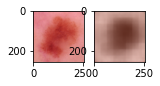

100%|██████████| 36/36 [00:01<00:00, 25.97it/s]


In [25]:
### Training the LatentNet ###

# Hyperparameters
batch_size = 32
learning_rate = 5e-4
latent_dim = 100


num_epochs = 25  # EPOCHS 

latent_net = LatentNet(latent_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate)


@tf.function
def debiasing_train_step(x, y):

  with tf.GradientTape() as tape:
    y_logit, z_mean, z_logsigma, x_recon = latent_net(x)

    loss, class_loss = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)

  grads = tape.gradient(loss, latent_net.trainable_variables)
  optimizer.apply_gradients(zip(grads, latent_net.trainable_variables))
  return loss

# get training faces from data loader
all_mel = images[pos_train_inds]

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

# The training loop -- outer loop iterates over the number of epochs
for i in range(num_epochs):

  IPython.display.clear_output(wait=True)
  print("Starting epoch {}/{}".format(i+1, num_epochs))

  # Recompute data sampling proabilities
  '''TODO: recompute the sampling probabilities for debiasing'''
  p_mel = get_training_sample_probabilities(all_mel, latent_net) 
  
  # get a batch of training data and compute the training step
  for j in tqdm(range(n_train_samples // batch_size)):
    # load a batch of data
    (x, y) = get_batch(batch_size, p_pos=p_mel)
    # loss optimization
    loss = debiasing_train_step(x, y)
    
    # plot the progress every 200 steps
    if j % 500 == 0: 
      mdl.util.plot_sample(x, y, latent_net)

In [26]:
(batch_x, batch_y) = get_batch(1000)
latent_net_logits = [latent_net.predict(np.array(x.reshape(1, 256, 256, 3), dtype=np.float32)) for x in batch_x]
latent_net_probs = tf.squeeze(tf.sigmoid(latent_net_logits))
preds = [np.array([1.0]) if pred > 0.5 else np.array([0.0]) for pred in latent_net_probs]
preds = np.array(preds)
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, preds), tf.float32))

print("LatentNet accuracy on training set: {:.4f}".format(acc_standard.numpy()))

LatentNet accuracy on training set: 0.9050


In [27]:
def test(path):
    latent_net_preds = []
    reg_preds = []
    for img in os.listdir(path):
        full_path = os.path.join(path, img)
        loaded = imgPrep.load_img(full_path, target_size=(256, 256))
        arr = imgPrep.img_to_array(loaded)/255.0
        pred1 = tf.sigmoid(latent_net.predict(arr.reshape(1, 256, 256, 3)))
        pred2 = tf.sigmoid(model.predict(arr.reshape(1, 256, 256, 3)))
        latent_net_preds.append(np.array(pred1)[0][0]); reg_preds.append(np.array(pred2)[0][0])
    print(f'LatentNet Confidence: {sum(latent_net_preds)/len(latent_net_preds)}')
    print(f'Standard Confidence: {sum(reg_preds)/len(reg_preds)}')
    return latent_net_preds, reg_preds

In [28]:
normal_hair = f'../input/melanoma-h5-dataset/---Full Validation Sets---v7/---Full Validation Sets---/Hair Density/Normal'
mel_hair = f'../input/melanoma-h5-dataset/---Full Validation Sets---v7/---Full Validation Sets---/Hair Density/Melanoma'
normal_type_1 = f'../input/melanoma-h5-dataset/---Full Validation Sets---v7/---Full Validation Sets---/Skin Type/Normal/Type I'
mel_type_1 = f'../input/melanoma-h5-dataset/---Full Validation Sets---v7/---Full Validation Sets---/Skin Type/Melanoma/Type I'
normal_type_2 = f'../input/melanoma-h5-dataset/---Full Validation Sets---v7/---Full Validation Sets---/Skin Type/Normal/Type II'
mel_type_2 = f'../input/melanoma-h5-dataset/---Full Validation Sets---v7/---Full Validation Sets---/Skin Type/Melanoma/Type II'
normal_type_3 = f'../input/melanoma-h5-dataset/---Full Validation Sets---v7/---Full Validation Sets---/Skin Type/Normal/Type III'
mel_type_3 = f'../input/melanoma-h5-dataset/---Full Validation Sets---v7/---Full Validation Sets---/Skin Type/Melanoma/Type III'
mel_paths = [mel_type_1, mel_type_2, mel_type_3]
norm_paths = [normal_type_1, normal_type_2, normal_type_3]

In [29]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [30]:
def get_all_accs(norm_paths, mel_paths, latent_weight=0.8, dcnn_weight=0.2):
    total = 0
    correct_norm = 0
    correct_db = 0
    correct_ens = 0
    latent_preds = []
    ens_preds = []
    tru_preds = []
    norm_preds = []
    for path in norm_paths:
        imgs = [os.path.join(path, img) for img in os.listdir(path)]
        for i, img in enumerate(imgs):
            loaded = imgPrep.load_img(img, target_size=(256, 256))
            arr = imgPrep.img_to_array(loaded)/255.
            pred1 = tf.sigmoid(latent_net.predict(arr.reshape(1, 256, 256, 3)))
            pred2 = tf.sigmoid(model.predict(arr.reshape(1, 256, 256, 3)))
            pred3 = pred1*dcnn_weight + pred2*latent_weight
            correct_db += int(pred1 < 0.5)
            correct_norm += int(pred2 < 0.5)
            correct_ens += int(pred2 < 0.5)
            norm_preds.append(np.array(pred2)[0][0])
            latent_preds.append(np.array(pred1)[0][0])
            ens_preds.append(np.array(pred3)[0][0])
            tru_preds.append(0)
#             if i == 371: break
    for path in mel_paths:
        imgs = [os.path.join(path, img) for img in os.listdir(path)]
        for i, img in enumerate(imgs):
            loaded = imgPrep.load_img(img, target_size=(256, 256))
            arr = imgPrep.img_to_array(loaded)/255.
            pred1 = tf.sigmoid(latent_net.predict(arr.reshape(1, 256, 256, 3)))
            pred2 = tf.sigmoid(model.predict(arr.reshape(1, 256, 256, 3)))
            pred3 = pred1*dcnn_weight + pred2*latent_weight
            correct_db += int(pred1 >= 0.5)
            correct_norm += int(pred2 >= 0.5)
            correct_ens += int(pred3 >= 0.5)
            norm_preds.append(np.array(pred2)[0][0])
            latent_preds.append(np.array(pred1)[0][0])
            ens_preds.append(np.array(pred3)[0][0])
            tru_preds.append(1)
            
    db_confusion = confusion_matrix(tru_preds, [1 if pred > 0.5 else 0 for pred in latent_preds])
    reg_confusion = confusion_matrix(tru_preds, [1 if pred > 0.5 else 0 for pred in norm_preds])
    ens_confusion = confusion_matrix(tru_preds, [1 if pred > 0.5 else 0 for pred in ens_preds])
    plot_confusion_matrix(cm = db_confusion, 
                          normalize = False,
                          target_names = ['No Melanoma', 'Melanoma'],
                          title = f"LatentNet Confusion Matrix")
    plot_confusion_matrix(cm = reg_confusion, 
                          normalize = False,
                          target_names = ['No Melanoma', 'Melanoma'],
                          title = f"DCNN Confusion Matrix")
    plot_confusion_matrix(cm = ens_confusion, 
                          normalize = False,
                          target_names = ['No Melanoma', 'Melanoma'],
                          title = f"Ensemble Confusion Matrix; Latent: {latent_weight}, DCNN: {dcnn_weight}")

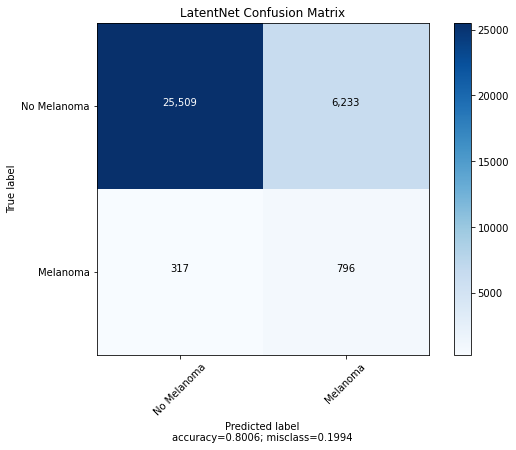

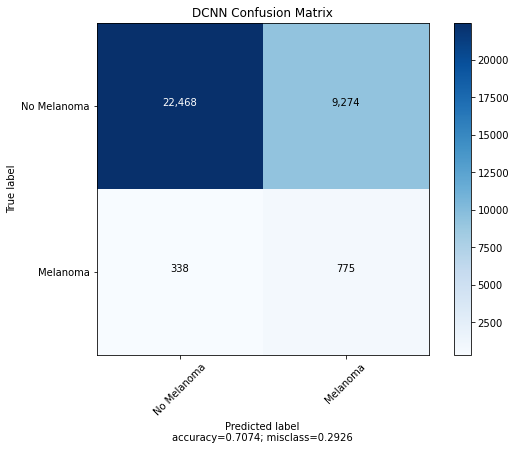

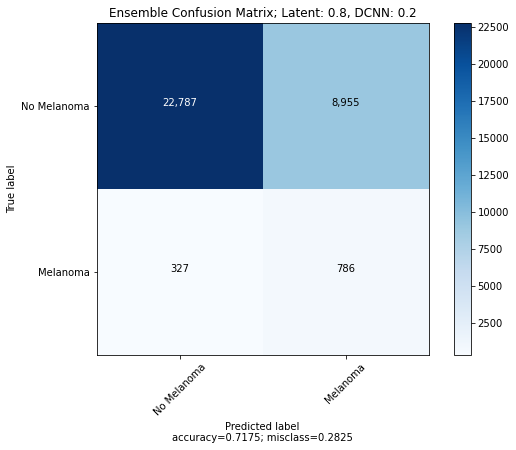

In [31]:
get_all_accs(norm_paths, mel_paths)